# DiploDatos Kaggle Competition

## Introducción

Presentamos un código creado como ejemplo de base para la competición.

Deben:

- Explorar los datos y aprender de ellos.
- Probar diferentes modelos y ver cuáles ajustan mejor dado los datos.
- **Obtener una accuracy mejor que la que se presenta en este ejemplo.**
- Tratar de obtener la accuracy más alta posible!
- Discutir la elección de modelo.

El análisis exploratorio y el preprocesamiento de los datos queda a libertad de cada grupo y no deben quedarse con este simple ejemplo.

## Paquetes de Python y Setup

Se importan los paquetes necesarios para este notebook
- *pandas*
- *numpy*
- *tensorflow*
- *seaborn*
- *matplotlib*
- *sklearn*
- *xgboost*
- *imblearn*

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

from imblearn.combine import SMOTETomek
from lightgbm import LGBMClassifier

## Leer el dataset

Se cargan los archivos de entrenamiento y prueba

In [ ]:
train_df = pd.read_csv('https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/Pr%C3%A1ctico/diabetes_prediction_dataset_train-labeled.csv')

In [ ]:
test_df = pd.read_csv('https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/Pr%C3%A1ctico/diabetes_prediction_dataset_test.csv')

In [ ]:
print(f'Train shape:\t{train_df.shape[0]}')
print(f'Test shape:\t{test_df.shape[0]}')

Train shape:	95000
Test shape:	5000


## Analisis de los datos


Es necesario conocer la variable objetivo `diabetes` del dataset

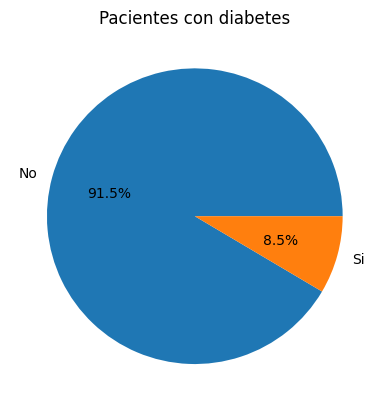

In [ ]:
plt.pie(train_df.diabetes.value_counts(), labels=['No','Si'], autopct='%1.1f%%')
plt.title('Pacientes con diabetes')
plt.show()

Se puede observar que la variable objetivo esta muy desbalanceada. Se debe tener en cuenta esto a la hora de entrenar el modelo. Se crea un histograma por cada variable para ver su compartamiento con respecto a la variable objetivo

### Histogramas

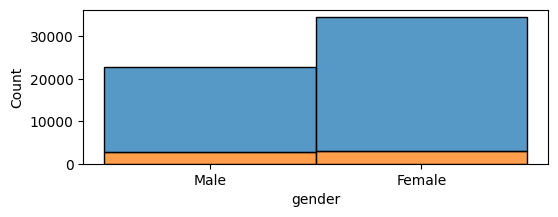

In [ ]:
fig = plt.figure(figsize=(6,2))
sns.histplot(data=train_df, x="gender", hue="diabetes", multiple="stack", bins=50, legend=False)
plt.show()

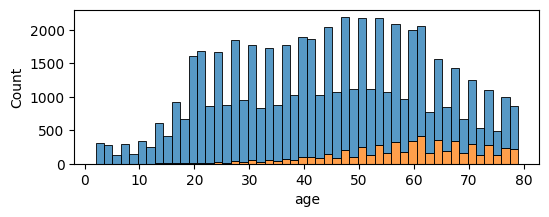

In [ ]:
fig = plt.figure(figsize=(6,2))
sns.histplot(data=train_df, x="age", hue="diabetes", multiple="stack", bins=50, legend=False)
plt.show()

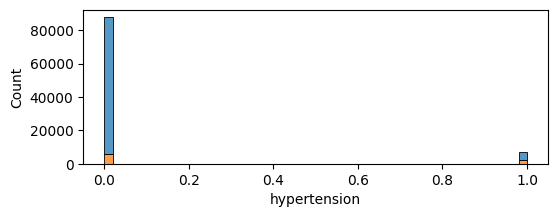

In [ ]:
fig = plt.figure(figsize=(6,2))
sns.histplot(data=train_df, x="hypertension", hue="diabetes", multiple="stack", bins=50, legend=False)
plt.show()

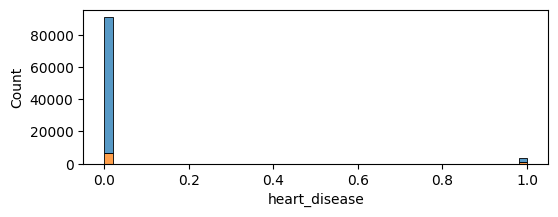

In [ ]:
fig = plt.figure(figsize=(6,2))
sns.histplot(data=train_df, x="heart_disease", hue="diabetes", multiple="stack", bins=50, legend=False)
plt.show()

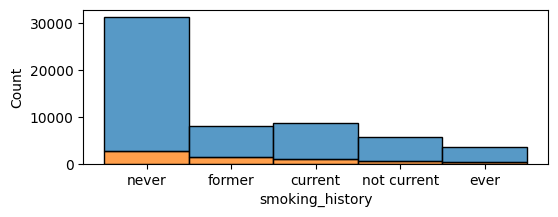

In [ ]:
fig = plt.figure(figsize=(6,2))
sns.histplot(data=train_df, x="smoking_history", hue="diabetes", multiple="stack", bins=50, legend=False)
plt.show()

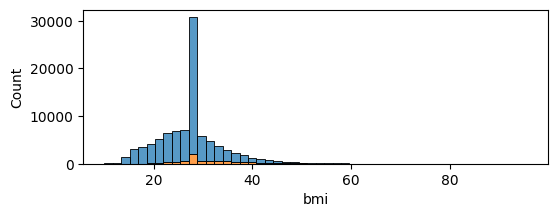

In [ ]:
fig = plt.figure(figsize=(6,2))
sns.histplot(data=train_df, x="bmi", hue="diabetes", multiple="stack", bins=50, legend=False)
plt.show()

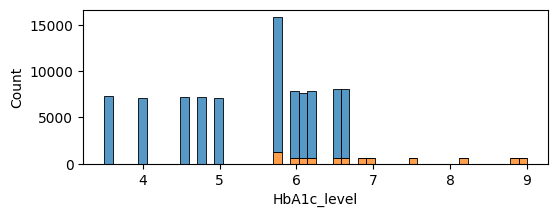

In [ ]:
fig = plt.figure(figsize=(6,2))
sns.histplot(data=train_df, x="HbA1c_level", hue="diabetes", multiple="stack", bins=50, legend=False)
plt.show()

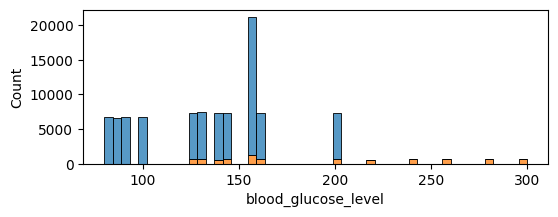

In [ ]:
fig = plt.figure(figsize=(6,2))
sns.histplot(data=train_df, x="blood_glucose_level", hue="diabetes", multiple="stack", bins=50, legend=False)
plt.show()

Luego de observar los histogramas se obtienen las siguientes conclusiones:
- age: presenta cierta discrepancia, ya que muestra que la gran mayoría de pacientes tiene 80 años y viendo la distribución de todas las edades, puede ser erróneo
- bmi: presenta una gran cantidad de datos alrededor de 27, pero esto corresponde a un valor esperado para una persona "saludable"
- smoke_history: se puede observar que la categoría **No_Info**, es decir los datos faltantes, tiene una gran cantidad de valores

## Preprocesamiento de datos


A partir del análisis realizado, se crea una función `preprocess_data` que realiza las siguientes tareas:
- Elimina las filas con valores `No_Info` de `smoking_history`
- Elimina las filas con valors `Other` de `gender`
- Elimina los valores iguales a 80 y menores a 2 de `age`
- Codifica los valores de las variables categoricas de `gender` y `smoking_history`
- Aplica `StandardScaler()`

In [ ]:
def preprocess_data(df):
    new_df = df.copy(deep=True)
    new_df = new_df[new_df['smoking_history'] != 'No Info']
    new_df = new_df[new_df['gender'] != 'Other']
    new_df = new_df[(new_df['age'] != 80) & (new_df['age'] >= 2)]

    new_df = pd.get_dummies(new_df, columns=['gender', 'smoking_history'], dtype=float)
    scaler = StandardScaler()
    new_df[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']] = scaler.fit_transform(new_df[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']])

    return new_df

In [ ]:
df = preprocess_data(train_df)

Se obtiene un dataset de entrenamiento menor al original

In [ ]:
df.shape

(57233, 15)

### Submuestreo

Al tener la variable objetico `diabetes` desbalanceada, se prodece a utilizar la técnica de submuestreo

Al tener la variable objetico `diabetes` desbalanceada, se prodece a utilizar la técnica de submuestreo SMOTETomek. Combina dos métodos, sobremuestreo y submuestreo para el balanceo de conjuntos de datos desequilibrados:

- SMOTE (Synthetic Minority Over-sampling Technique): Esta técnica genera nuevas muestras sintéticas de la clase minoritaria. Lo hace seleccionando aleatoriamente una muestra de la clase minoritaria y encontrando sus k vecinos más cercanos. Luego, crea un nuevo ejemplo sintético en el espacio entre la muestra seleccionada y uno de sus vecinos

- Tomek Links: Es una técnica de submuestreo que identifica y elimina parejas de ejemplos (un ejemplo de la clase mayoritaria y otro de la clase minoritaria) que son los vecinos más cercanos entre sí y pertenecen a diferentes clases. Si un par de ejemplos es un Tomek Link, significa que la frontera de decisión entre las clases es ruidosa en ese punto, y eliminando estos ejemplos se puede mejorar la separación entre clases

Ver [link](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTETomek.html)

In [ ]:
def smote_tomek(df):
    X = df.drop('diabetes', axis=1)
    y = df['diabetes']

    smote_tomek = SMOTETomek(random_state=42)
    X_resampled, y_resampled = smote_tomek.fit_resample(X, y)
    resampled_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['diabetes'])], axis=1)

    X = resampled_df.drop(columns= 'diabetes')
    y = resampled_df['diabetes']

    return X, y

**Aclaración: No se utilizo `SMOTETomek` para la entrega del trabajo**

In [ ]:
#X, y = smote_tomek(df)

Se extran la columna `patient` y se separan los datos

In [ ]:
PatientId_train = df['patient']
df = df.drop('patient', axis=1)

In [ ]:
X = df.drop(columns = 'diabetes')
y = df['diabetes']

Se utilizar `test_train_split` para separar los datos de entrenamiento

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Clasificador por votación

Un clasificador de votación es un modelo de aprendizaje automático que adquiere experiencia entrenando en un conjunto de varios modelos y pronostica una salida (clase) basada en la clase con mayor probabilidad de convertirse en la salida.




Se basa en construir un modelo único que aprenda de varios modelos y que pueda predecir en función de la mayoría de votos para cada modelo, en lugar de construir modelos especializados separados y determinar la precisión de cada uno de ellos. Existen principalmente dos tipos diferentes de clasificadores de votación:

- `hard`: la salida prevista es la clase con la mayor cantidad de votos, es decir, la clase con la mayor probabilidad de ser predicha por cada modelo.
- `soft`: las probabilidades promedio de los modelos determinan cuál será la predicción final

A partir de esto se plantean dos modelos:
- `XGBClassifier`: Un clasificador basado en el algoritmo de Gradient Boosting de XGBoost, conocido por su eficiencia y flexibilidad
- `RandomForestClassifier`: Un clasificador basado en el algoritmo de Random Forest, que construye múltiples árboles de decisión y combina sus predicciones para mejorar la precisión y reducir el sobreajuste



### Sin ajuste de hiperparámetros

Primero se instancia el clasificador por votacíon mediante `VotingClassifier` con los modelos mencionados sin ajustar hiperparámetros

In [ ]:
xgb = XGBClassifier(random_state=6)
rf = RandomForestClassifier(random_state=6)

In [ ]:
voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb)],
    voting='soft'
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=6)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=6, ...))],
                 voting='soft')

Accuracy train voting_clf: 98.4384%
Accuracy test voting_clf: 96.5231%


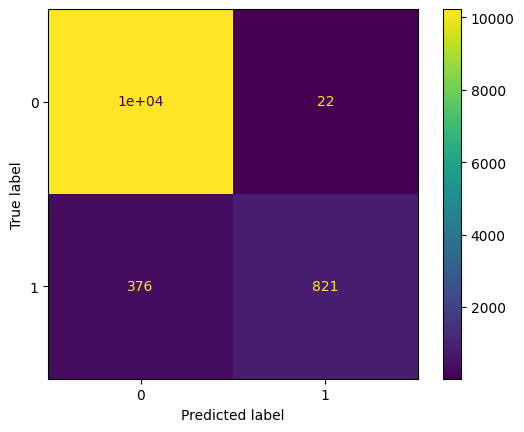

In [ ]:
name = 'voting_clf'
train_predictions = voting_clf.predict(X_train)
accuracy = accuracy_score(y_train, train_predictions)
print(f"Accuracy train {name}: %.4f%%" % (accuracy * 100.0))

test_predictions = voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, test_predictions)
print(f"Accuracy test {name}: %.4f%%" % (accuracy * 100.0))
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)
plt.show()

### Con ajuste de hyperparámetros

Ahora si instancia el mismo modelo, pero con ajuste de hiperparámetros. Para este caso se utiliza la GPU para entrenar más rápido el modelo `XGBClassifier`

In [ ]:
print("GPU está", "disponible" if tf.config.list_physical_devices('GPU') else "no disponible")

GPU está disponible


In [ ]:
rf = RandomForestClassifier(random_state=6)
xgb_clf = XGBClassifier(device='cuda', random_state=6)

In [ ]:
voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb_clf)],
    voting='soft'
)

param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20, 30],
    'xgb__n_estimators': [50, 100, 200],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__max_depth': [3, 6, 9]
}

grid_search = GridSearchCV(estimator=voting_clf, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=VotingClassifier(estimators=[('rf',
                                                     RandomForestClassifier(random_state=6)),
                                                    ('xgb',
                                                     XGBClassifier(base_score=None,
                                                                   booster=None,
                                                                   callbacks=None,
                                                                   colsample_bylevel=None,
                                                                   colsample_bynode=None,
                                                                   colsample_bytree=None,
                                                                   device='cuda',
                                                                   early_stopping_rounds=None,
                                                                   enable_categorical=False,
                                                                   eval_metric=None,
                                                                   feature_types=None,
                                                                   gamma=None,
                                                                   gr...
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=None,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   random_state=6, ...))],
                                        voting='soft'),
             param_grid={'rf__max_depth': [None, 10, 20, 30],
                         'rf__n_estimators': [50, 100, 200],
                         'xgb__learning_rate': [0.01, 0.1, 0.2],
                         'xgb__max_depth': [3, 6, 9],
                         'xgb__n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [ ]:
print(f"Mejores hiperparámetros: {grid_search.best_params_}")
print(f"Mejor puntuación: {grid_search.best_score_}")

voting_clf = grid_search.best_estimator_

Mejores hiperparámetros: {'rf__max_depth': 10, 'rf__n_estimators': 200, 'xgb__learning_rate': 0.2, 'xgb__max_depth': 6, 'xgb__n_estimators': 50}
Mejor puntuación: 0.9658410418931807


Accuracy train voting_clf: 96.6911%
Accuracy test voting_clf: 96.5581%


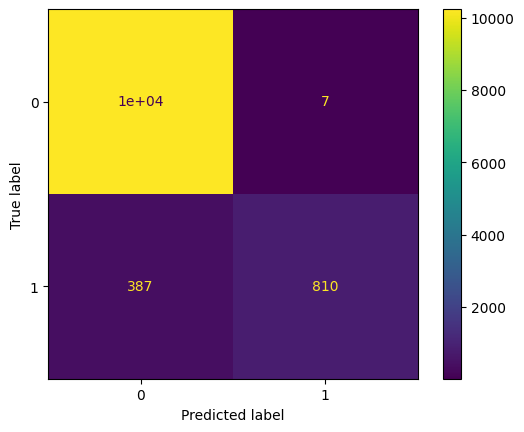

In [ ]:
name = 'voting_clf'
train_predictions = voting_clf.predict(X_train)
accuracy = accuracy_score(y_train, train_predictions)
print(f"Accuracy train {name}: %.4f%%" % (accuracy * 100.0))

test_predictions = voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, test_predictions)
print(f"Accuracy test {name}: %.4f%%" % (accuracy * 100.0))
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)
plt.show()

Se decide utilizar el modelo con ajuste de hiperparámetros llamado `voting_clf`

## Generar la salida para entregar

Se extrae la columna `patient` de `test_df`

In [ ]:
PatientId_test = test_df['patient']
test_df = test_df.drop('patient', axis=1)

Para poder evaluar nuestra predicción los datos de prueba deben tener exactamente el mismo tratamiento que los datos de entrenamiento

In [ ]:
test_df = pd.get_dummies(test_df, columns=['gender', 'smoking_history'], dtype=float)
scaler = StandardScaler()
test_df[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']] = scaler.fit_transform(test_df[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']])

In [ ]:
X_test = test_df.drop(['diabetes', 'gender_Other', 'smoking_history_No Info'] , axis=1)

In [ ]:
X_test

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,gender_Female,gender_Male,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,0.534851,0,0,0.683720,-0.950085,-0.294803,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-0.840774,0,0,-0.198857,0.997153,-0.195048,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.175149,0,0,-0.743333,0.626250,-0.294803,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.530149,0,0,0.540283,-0.486457,-1.441995,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.485774,0,0,0.196327,0.997153,-0.943216,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-0.796399,0,0,-0.665760,0.997153,1.550679,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4996,0.446101,0,0,0.000198,-1.413713,0.428426,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,1.688601,0,0,-0.515004,0.440799,-0.294803,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4998,-0.752024,0,0,-0.678933,0.533525,-1.317300,0.0,1.0,0.0,0.0,0.0,1.0,0.0


Generamos la salida

In [ ]:
test_id = PatientId_test
test_pred = np.int64(voting_clf.predict(X_test))

Con el resultado predicho tenemos que generar el archivo `.csv` para subir a la competencia de Kaggle:

In [ ]:
submission = pd.DataFrame(list(zip(test_id, test_pred)), columns=["patient", "diabetes"])
submission.to_csv("sample_submission_vc_ht.csv", header=True, index=False)

Se obtuvo los siguientes resultados en Kaggle:
- Public Score:    **0.97333**
- Private Score: **0.97314**